# Long short-term memory


# ECG Heartbeat Classification

In this exercise you will implement an LSTM neural network that can classify ambulatory ECG recordings into 5 different classes. 

# Collect Data
We use a preprocessed version of a famous datasets in heartbeat classification, [the MIT-BIH Arrhythmia Dataset](https://physionet.org/content/mitdb/1.0.0/). 
The signals in this dataset correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. We will use the Arrhythmia Dataset used in [this paper](https://arxiv.org/abs/1805.00794) which is the preprocessed arrhythmia dataset consisting of signals that are preprocessed and segmented, with each segment corresponding to a heartbeat in the dataset. This dataset is composed of 109446 samples which are classified into 5 categories. You must download the dataset from [here](https://drive.google.com/file/d/1a8IetOZkvnq8D8K6k8EdMsFGeqE2Hv5M/view?usp=sharing). It is also accessible on [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat).

The training and test data is located in mitbih_train.csv and mitbih_test.csv files. Locate these files in dataset folder next to this notebook. If you are running this notebook on colab (which is strongly recommended), the following code does this phase.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'MLB_RNN_Assignment/dataset'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd dataset
!unzip 29414_37484_bundle_archive.zip
!rm 29414_37484_bundle_archive.zip
%cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content
/content/dataset
Archive:  29414_37484_bundle_archive.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        
/content


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# Create Custom Dataset
You need to create your custom dataset so you can define a dataloader to use in the train and test phase. Your class must implement init, getitem and len methods.

In [4]:
class HeartbeatDataset(Dataset):
    def __init__(self, csv_file):
        super(HeartbeatDataset, self).__init__()
        self.X = pd.read_csv(csv_file, header=None, usecols=range(187)).to_numpy()
        self.y = pd.read_csv(csv_file, header=None, usecols=[187]).iloc[:,0].to_numpy(dtype=int)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

batch_size = 64

train_set = HeartbeatDataset('dataset/mitbih_train.csv')
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)                          

test_set = HeartbeatDataset('dataset/mitbih_test.csv')
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)                         

In [5]:
num_classes = 5
class_samples_num = [0 for i in range(num_classes)]
for data in train_loader:
    inputs, labels = data 
    for i in labels:
        class_samples_num[i] += 1
print(class_samples_num)

[72471, 2223, 5788, 641, 6431]


# Create LSTM Classifier
Now you are ready to implement your LSTM neural network which inherits from nn.Module. The structure of the network must be as follows:

  (lstm): LSTM(1, 64, batch_first=True)<br>
  (fc1): Linear(in_features=64, out_features=32, bias=True)<br>
  (relu): ReLU()<br>
  (fc2): Linear(in_features=32, out_features=5, bias=True)<br>

At each step the value of signal is given as input to the LSTM block. The hidden state and cell state get updated and the final output is computed by two fully connected after the final hidden state with a softmax layer at the end.



In [12]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, middle_dim, target_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, middle_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(middle_dim, target_dim, bias=True)

    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x.view(x.size(0), x.size(1), -1))
        out = hidden[-1].view(-1, self.hidden_dim)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define loss function and optimizer
Next you can instance a classifier, loss function and optimizer. You are free to change the loss function, the optimizer and their parameters along with dimensions of the hidden state and the fully connected layer of the classifier. Because of the imbalanced dataset, the model may tend to label the whole test data as normal. So we must make the model pay more attention to the minor cases. There are different ways to do so. One of them is the upsampling technique in which we produce enough samples for all categories, by resampling from the present data. Another way is to weight loss of each sample proportional to inverse of its caregory's number of samples. So weights of samples of each category sum to one, and the model pays equal attention to all categories. We are going to use this technique by providing the CrossEntropyLoss loss function an array of weights (You can also use other techniques like upsampling).

In [16]:
lstm_classifier = LSTMClassifier(1, 64, 32, num_classes)
lstm_classifier.to(device)
print(lstm_classifier)
num_samples = np.sum(class_samples_num)
loss_weight = num_samples / class_samples_num
loss_weight = torch.from_numpy(loss_weight / np.sum(loss_weight)).float()
print(loss_weight)
criterion = nn.CrossEntropyLoss(weight=loss_weight)
criterion.to(device)
optimizer = torch.optim.Adam(lstm_classifier.parameters())

LSTMClassifier(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)
tensor([0.0059, 0.1913, 0.0735, 0.6633, 0.0661])


# Train the classifier
The following code runs the training phase using what you have build so far. It also feeds the test data to the model at each epoch without updating the weights, so we can study the loss on both training and test data during the training phase by plotting its diagram at the end. You can edit the code.

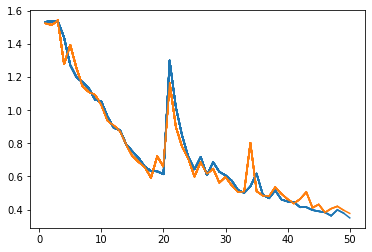

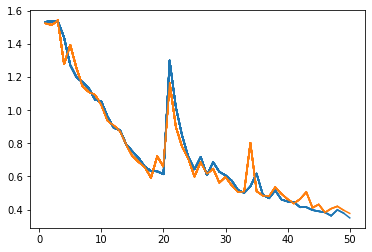

In [18]:
epoch_num = 50

train_log = []
test_log = []

for epoch in range(1, epoch_num+1):
    running_loss = 0    
    train_loss = []
    lstm_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = lstm_classifier(inputs.float())
        loss = criterion(outputs, labels)       
        loss.backward()                
        optimizer.step()        
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    lstm_classifier.eval()
    with torch.no_grad():                
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):         
            inputs, labels = inputs.to(device), labels.to(device)        
            outputs = lstm_classifier(inputs.float())                       
            loss = criterion(outputs, labels)            
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))    
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Test the classifier
The following code runs the LSTM classifier on test data and reports the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). It also reports the [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) which shows us how much we have succeeded in handling the imbalanced data. The ROC AUC score is the evaluation criterion of your model. ROC AUC score and accuracy of more than 0.9 are achievable by the model. You are supposed to achieve ROC AUC score and accuracy of at least 0.8.

In [20]:
y_true = []
y_pred = []
with torch.no_grad():
    lstm_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):         
        inputs, labels = inputs.to(device), labels.to(device)        
        outputs = lstm_classifier(inputs.float())                       
        y_true += torch.eye(num_classes)[labels].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))


ROC_AUC Score: 0.9477741091772709
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     18118
           1       0.22      0.77      0.35       556
           2       0.71      0.91      0.80      1448
           3       0.18      0.88      0.29       162
           4       0.93      0.95      0.94      1608

    accuracy                           0.87     21892
   macro avg       0.61      0.87      0.66     21892
weighted avg       0.94      0.87      0.89     21892



# Useful Links and Acknowledgements

[An Effective LSTM Recurrent Network to Detect Arrhythmia on Imbalanced ECG Dataset](https://www.hindawi.com/journals/jhe/2019/6320651/)

[Classify ECG Signals Using Long Short-Term Memory Networks
](https://https://www.mathworks.com/help/signal/examples/classify-ecg-signals-using-long-short-term-memory-networks.html)

[Sequence Models and Long-Short Term Memory Networks](https://https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

[LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)

[ECG Heartbeat Classification: A Deep Transferable Representation
](https://https://arxiv.org/abs/1805.00794)

[MIT-BIH Arrhythmia Database](https://https://physionet.org/content/mitdb/1.0.0/)